In [1]:
## Notes
## * Rows are *not* deleted from `cx_translations` when the translation drafts are purged

In [2]:
from dateutil.rrule import MONTHLY, MO
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from wmfdata import charting, hive
from wmfdata.utils import pd_display_all, insert_code_toggle

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [3]:
charting.set_mpl_style()
insert_code_toggle()

In [4]:
CHART_START = "2018-07"
MWH_SNAPSHOT = "2019-09" # This will also be the end of the charts
TARGET_WIKIS = ("mlwiki", "bnwiki", "tlwiki", "jvwiki", "mnwiki")

time_range = pd.period_range(CHART_START, MWH_SNAPSHOT, freq="W-MON")
time_end = time_range[-1].to_timestamp(how="end")

# If the last week goes past the end of mediawiki_history, remove it
if time_end > pd.Timestamp(MWH_SNAPSHOT):
    time_range = time_range[:-1]
    time_start = time_range[0].to_timestamp(how="start")
    time_end = time_range[-1].to_timestamp(how="end")
    
query_params = {
    "MWH_SNAPSHOT": MWH_SNAPSHOT,
    "time_start": time_start,
    "time_end": time_end
}

In [6]:
translations = hive.run("""
select
    event_user_text as translator,
    wiki_db as wiki,
    date_format(event_timestamp, "yyyy-MM-dd") as date,
    if(array_contains(revision_tags, "contenttranslation-v2"), 2, 1) as cx_version,
    if(
        coalesce(datediff(event_timestamp, ssac.dt) > 252, true), -- 6 months ≈ 26 weeks = 252 days
        "experienced",
        "new"
    ) as user_experience,
    if(revision_is_deleted_by_page_deletion, "deleted", "surviving") as status
from wmf.mediawiki_history mh
left join event_sanitized.serversideaccountcreation ssac
on
    ssac.event.username = event_user_text and
    ssac.year >= 0
where
    mh.snapshot = "{MWH_SNAPSHOT}" and
    mh.event_timestamp between "{time_start}" and "{time_end}" and
    event_entity = "revision" and
    event_type = "create" and
    array_contains(revision_tags, "contenttranslation")
""".format(**query_params)
).assign(
    date=lambda df: pd.to_datetime(df["date"])
).assign(
    week=lambda df: df["date"].dt.to_period("W-MON").dt.to_timestamp()
)

In [15]:
def plot_df(df):
    ax = df.plot.area()
    ylim = plt.ylim()
    plt.ylim((ylim[0], ylim[1] * 1.1))

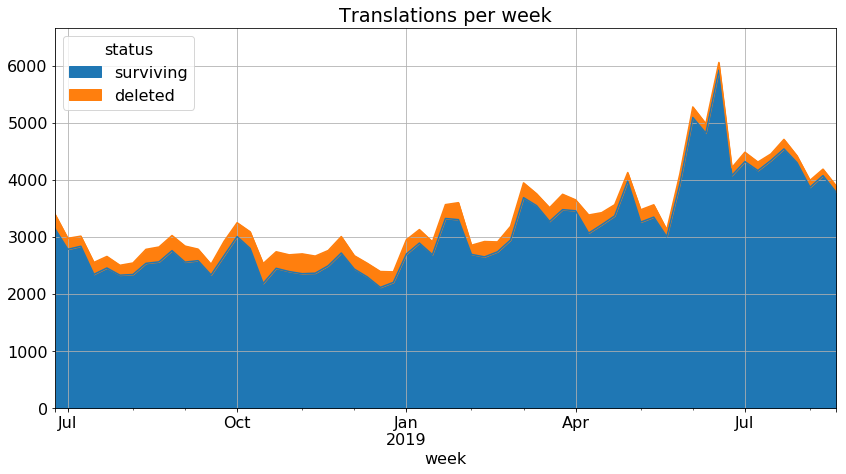

In [16]:
weekly_translations = translations.groupby(["week", "status"]).size().unstack()[["surviving", "deleted"]]

plot_df(weekly_translations)
plt.title("Translations per week");

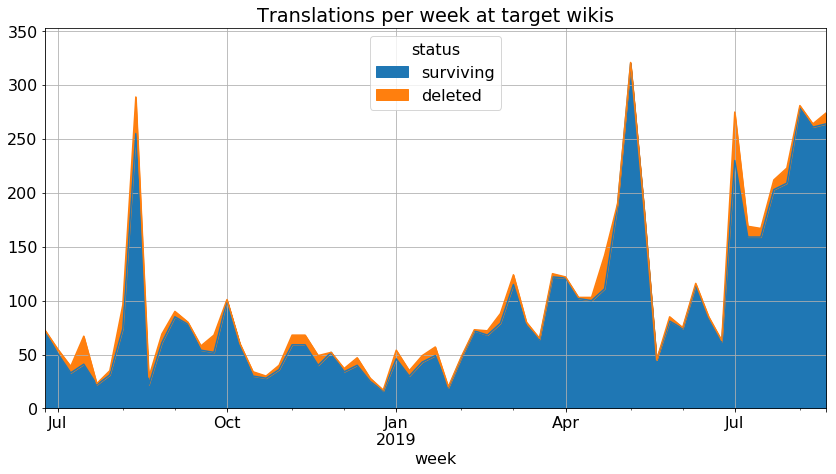

In [17]:
weekly_target_wiki_translations = (
    translations
    .query("wiki in @TARGET_WIKIS")
    .groupby(["week", "status"])
    .size()
    .unstack()
    [["surviving", "deleted"]]
)

plot_df(weekly_target_wiki_translations)
plt.title("Translations per week at target wikis");

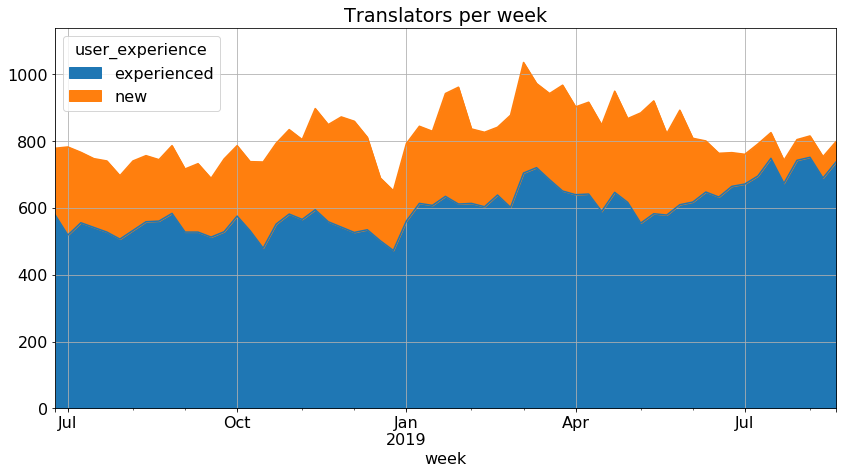

In [18]:
weekly_translators = translations.groupby(["week", "user_experience"]).nunique()["translator"].unstack()
plot_df(weekly_translators)
plt.title("Translators per week");

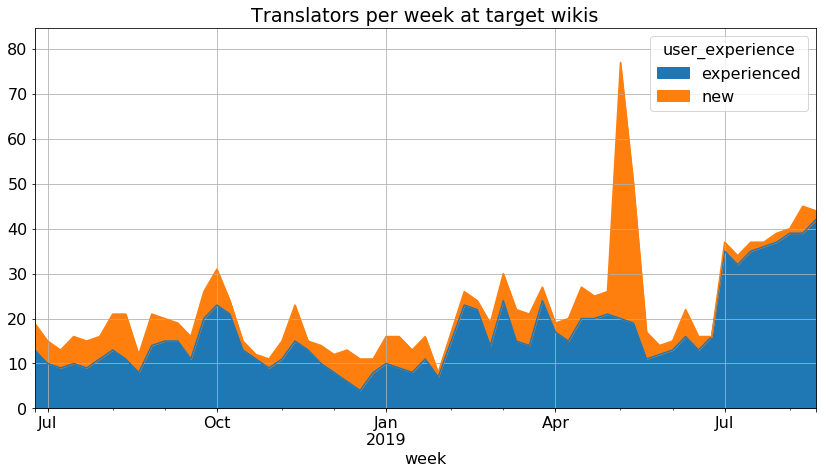

In [19]:
weekly_target_wiki_translators = (
    translations
    .query("wiki in @TARGET_WIKIS")
    .groupby(["week", "user_experience"])
    .nunique()["translator"]
    .unstack()
)

plot_df(weekly_target_wiki_translators)
plt.title("Translators per week at target wikis");

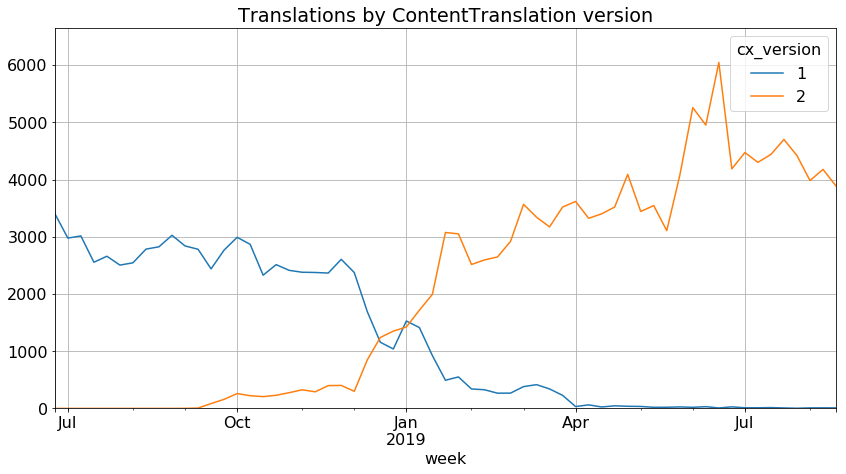

In [24]:
translations_by_version = translations.groupby(["week", "cx_version"]).size().unstack().fillna(0)
translations_by_version.plot()
ylim = plt.ylim()
plt.ylim((0, ylim[1] * 1.1))
plt.title("Translations by ContentTranslation version");

In [58]:
(
    translations_by_version
    .set_index(translations_by_version.index.strftime("%Y-%m-%d"))
    .rename_axis("week")
    .tail()
    .style.format("{:.0f}")
)

cx_version,1,2
week,,
2019-07-23,8,4701
2019-07-30,3,4419
2019-08-06,9,3983
2019-08-13,10,4178
2019-08-20,9,3888


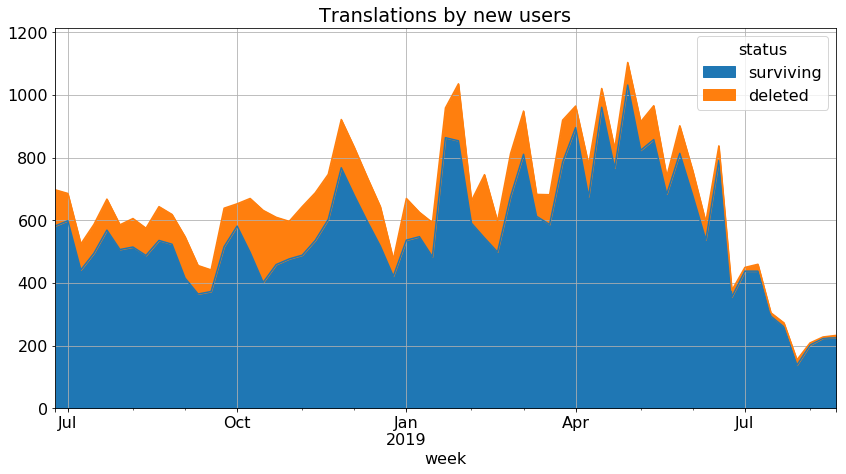

In [73]:
newcomer_translations = (
    translations.query("user_experience == 'new'")
    .groupby(['week', 'status'])
    .size()
    .unstack()
    .reindex(["surviving", "deleted"], axis=1)
)

plot_df(newcomer_translations)
plt.title('Translations by new users');

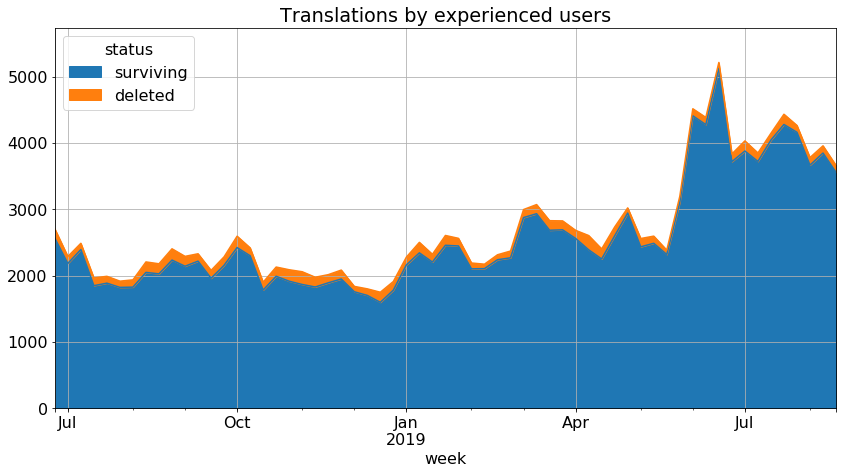

In [74]:
experienced_translations = (
    translations.query("user_experience == 'experienced'")
    .groupby(['week', 'status'])
    .size()
    .unstack()
    .reindex(["surviving", "deleted"], axis=1)
)

plot_df(experienced_translations)
plt.title('Translations by experienced users');

In [83]:
now = pd.Timestamp.utcnow()
now_date = now.strftime("%Y-%m-%d")
now_time = now.strftime("%H:%M %Z")

print("This dashboard was generated on {} at {}.".format(now_date, now_time))

This dashboard was generated on 2019-10-15 at 16:30 UTC.
